# Ecosystem Simulation

This notebook simulates the dynamics between three ecosystem components:
- Plants (producer)
- Rabbits (herbivores/prey)
- Wolves (predators)

The simulation tracks population sizes and interactions over time.

In [1]:
import random

class Plant:
    def __init__(self, size, max_size, grow_rate):
        # self.type = type
        self.size = size
        self.grow_rate = grow_rate
        self.min_size = 5
        self.max_size = max_size

    def step(self):
        # self.size += min(self.size * self.grow_rate, 40)
        # self.size *= self.grow_rate
        self.size *= 1.2
        self.size += (self.grow_rate * self.max_size)

        if self.size > self.max_size:
            self.size = self.max_size

        if self.size <= self.min_size:
            self.size = self.min_size

    def update(self, eat_amount):
        self.size -= eat_amount
        if self.size <= self.min_size:
            self.size = self.min_size

class Animal:
    def __init__(self, type, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        self.type = type
        self.eat_amount = max(eat_amount, 2)
        self.eat_rate = max(eat_rate, 0.1)

        self.emergency_eat_ratio = max(emergency_eat_ratio, 1)
        self.breed_rate = max(breed_rate, 0.1)

        self.is_alive = True
        self.hunger = 100 # If zero, the animal is dead.

    def step(self):
        if self.hunger < 0:
            self.is_alive = False

    def print(self):
        print(f"{self.type} - {self.hunger} - {self.eat_amount} - {self.eat_rate} - {self.emergency_eat_ratio} - {self.breed_rate}")

class Rabbit(Animal):
    def __init__(self, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        super().__init__('prey', eat_amount, eat_rate, emergency_eat_ratio, breed_rate)
        self.hunger = 60
        self.max_hunger = 60
        self.actions = []

    def step(self, plant: Plant):
        step_cost = max(self.eat_amount // 3, 4)
        if self.hunger < self.max_hunger:
            step_cost *= 1.6
            step_cost = int(step_cost)

        self.hunger -= step_cost

        self.actions = []

        # Choose action between eating and sleeping.
        # Force to eat if hunger is low.
        if self.hunger < self.eat_amount * self.emergency_eat_ratio:
            self.actions.append('eat')

        # Choose action based on random chance.
        elif random.random() < self.eat_rate:
            self.actions.append('eat')

        else:
            self.actions.append('sleep')

        # Choose action based on random chance.
        if random.random() < self.breed_rate:
            self.actions.append('breeding')

        for action in self.actions:
            # self.hunger -= self.action_cost[action]
            if action == 'eat':
                if self.eat_amount < plant.size * random.uniform(1, 1.2):
                    num_eaten = random.randint(self.eat_amount, int(self.eat_amount * (1 + self.eat_rate)))

                    self.hunger += num_eaten
                    self.hunger = min(self.hunger, self.max_hunger)
                    plant.update(self.eat_amount * random.uniform(0.7, 1))
                else:
                    self.hunger -= step_cost

            if self.hunger < 0:
                self.is_alive = False
                break

        # print(f"Rabbit hunger: {self.actions}", self.hunger, step_cost)

    def breed(self, other_rabbit):
        self.hunger -= self.eat_amount // 6
        other_rabbit.hunger -= self.eat_amount // 6 # Use father's eat amount
        # rabbit = Rabbit(self.eat_amount, self.eat_rate, self.emergency_eat_ratio, self.breed_rate)
        # rabbit.hunger /= 2
        # return rabbit

        shared_eat_amount = int((self.eat_amount + other_rabbit.eat_amount) / 2 + random.randint(-1, 1))
        shared_eat_rate = (self.eat_rate + other_rabbit.eat_rate) / 2 + random.uniform(-0.1, 0.1)
        shared_emergency_eat_ratio = (self.emergency_eat_ratio + other_rabbit.emergency_eat_ratio) / 2 + random.uniform(-0.1, 0.1)
        shared_breed_rate = (self.breed_rate + other_rabbit.breed_rate) / 2 + random.uniform(-0.1, 0.1)
        rabbit = Rabbit(shared_eat_amount, shared_eat_rate, shared_emergency_eat_ratio, shared_breed_rate)
        rabbit.hunger = int((self.hunger + other_rabbit.hunger) / 2)

        return rabbit

class Wolf(Animal):
    def __init__(self, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        super().__init__('predator', eat_amount, eat_rate, emergency_eat_ratio, breed_rate)
        self.hunger = 100
        self.max_hunger = 120
        self.actions = []

    def step(self, rabbit: Rabbit, num_rabbits: int):
        step_cost = max(self.eat_amount // 3, 6)  # Wolves use more energy than rabbits
        if self.hunger < self.max_hunger / 2:
            step_cost *= 1.2
            step_cost = int(step_cost)

        self.hunger -= step_cost
        self.actions = []

        # Choose action between hunting and sleeping
        # Force to hunt if hunger is low
        if self.hunger < self.eat_amount * self.emergency_eat_ratio:
            self.actions.append('hunt')
        elif random.random() < self.eat_rate:
            self.actions.append('hunt')
        else:
            self.actions.append('sleep')

        # Choose action based on random chance
        if random.random() < self.breed_rate:
            self.actions.append('breeding')

        for action in self.actions:
            if action == 'hunt' and rabbit is not None and rabbit.is_alive:
                # Wolves have a chance to catch rabbits based on their hunger level
                # hunt_success_rate = num_rabbits / 150
                hunt_success_rate = random.uniform(0.4, 0.8) if 'eat' in rabbit.actions else 0.05
                if random.random() < hunt_success_rate:
                    nutrition = min(self.eat_amount, rabbit.hunger)
                    self.hunger += nutrition * 4  # Rabbits provide more nutrition than plants
                    self.hunger = min(self.hunger, self.max_hunger)
                    rabbit.is_alive = False  # Rabbit gets eaten
                else:
                    # Failed hunt costs extra energy
                    self.hunger -= step_cost

            if self.hunger < 0:
                self.is_alive = False
                break

    def breed(self, other_wolf):
        # Breeding costs energy
        self.hunger -= self.eat_amount // 4
        other_wolf.hunger -= self.eat_amount // 4

        # Create offspring with mixed traits from parents
        shared_eat_amount = int((self.eat_amount + other_wolf.eat_amount) / 2 + random.randint(-2, 2))
        shared_eat_rate = (self.eat_rate + other_wolf.eat_rate) / 2 + random.uniform(-0.05, 0.05)
        shared_emergency_eat_ratio = (self.emergency_eat_ratio + other_wolf.emergency_eat_ratio) / 2 + random.uniform(-0.1, 0.1)
        shared_breed_rate = (self.breed_rate + other_wolf.breed_rate) / 2 + random.uniform(-0.05, 0.05)

        wolf = Wolf(shared_eat_amount, shared_eat_rate, shared_emergency_eat_ratio, shared_breed_rate)
        wolf.hunger = int((self.hunger + other_wolf.hunger) / 2)

        return wolf

In [2]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class RabbitProperties:
    eat_amount: Tuple[int, int]
    eat_rate: Tuple[float, float]
    emergency_eat_ratio: Tuple[float, float]
    breed_rate: Tuple[float, float]
    num_rabbits: int

@dataclass
class WolfProperties:
    eat_amount: Tuple[int, int]
    eat_rate: Tuple[float, float]
    emergency_eat_ratio: Tuple[float, float]
    breed_rate: Tuple[float, float]
    num_wolves: int

@dataclass
class PlantProperties:
    size: float
    max_size: float
    grow_rate: float

class Environment:
    def __init__(self, rabbit_properties: RabbitProperties, plant_properties: PlantProperties, wolf_properties: WolfProperties = None):
        self.ep = 0
        self.rabbits = [
            Rabbit(
                eat_amount=random.randint(*rabbit_properties.eat_amount),
                eat_rate=random.uniform(*rabbit_properties.eat_rate),
                emergency_eat_ratio=random.uniform(*rabbit_properties.emergency_eat_ratio),
                breed_rate=random.uniform(*rabbit_properties.breed_rate),
            ) for _ in range(rabbit_properties.num_rabbits)
        ] # Reduced eat amount, increased eat rate

        self.wolves = []
        if wolf_properties:
            self.wolves = [
                Wolf(
                    eat_amount=random.randint(*wolf_properties.eat_amount),
                    eat_rate=random.uniform(*wolf_properties.eat_rate),
                    emergency_eat_ratio=random.uniform(*wolf_properties.emergency_eat_ratio),
                    breed_rate=random.uniform(*wolf_properties.breed_rate),
                ) for _ in range(wolf_properties.num_wolves)
            ]

        # self.plant = Plant(100, 150, 1.5) # Increased growth rate (was 0.2)
        self.plant = Plant(
            size=plant_properties.size,
            max_size=plant_properties.max_size,
            grow_rate=plant_properties.grow_rate
        )

        self.report = []

    def update_report(self):
        report = {
            'num_rabbits': len(self.rabbits),
            'num_wolves': len(self.wolves),
            'plant_size': self.plant.size,
            # 'rabbit_hunger': [rabbit.hunger for rabbit in self.rabbits],
            # 'wolf_hunger': [wolf.hunger for wolf in self.wolves],
        }
        self.report.append(report)

    def remove_dead_animals(self):
        self.rabbits = [rabbit for rabbit in self.rabbits if rabbit.is_alive]
        self.wolves = [wolf for wolf in self.wolves if wolf.is_alive]

    def simulate(self):
        self.update_report()

        for rabit in self.rabbits:
            rabit.step(self.plant)

        self.report[-1]['plant_size'] = self.plant.size
        # eating_rabbits = [rabbit for rabbit in self.rabbits if 'eat' in rabbit.actions]

        if len(self.rabbits) > 0:
            selected_rabbits = random.choices(self.rabbits, k=len(self.wolves))
        else:
            selected_rabbits = [None] * len(self.wolves)

        for i, wolf in enumerate(self.wolves):
            wolf.step(selected_rabbits[i], len(self.rabbits))

        self.remove_dead_animals()
        breeding_rabbits = [rabbit for rabbit in self.rabbits if 'breeding' in rabbit.actions]
        new_rabbits = []

        food_quota = self.plant.size / 10
        food_consume = 0

        # Random group of rabbits breed with no duplicates.
        for i in range(len(breeding_rabbits)):
            if not breeding_rabbits[i].is_alive or 'breeding' not in breeding_rabbits[i].actions:
                continue

            random_mate = random.choice(breeding_rabbits)
            if i == breeding_rabbits.index(random_mate) or 'breeding' not in random_mate.actions:
                continue

            food_consume += (breeding_rabbits[i].eat_amount + random_mate.eat_amount) / 2
            # print(self.ep, i, food_consume, food_quota)
            if food_consume >= food_quota:
                break

            new_rabbit = breeding_rabbits[i].breed(random_mate)
            breeding_rabbits[i].actions.remove('breeding')
            random_mate.actions.remove('breeding')


            if new_rabbit:
                new_rabbits.append(new_rabbit)

        self.rabbits.extend(new_rabbits)

        new_wolves = []
        breeding_wolves = [wolf for wolf in self.wolves if 'breeding' in wolf.actions]

        # Random group of wolves breed with no duplicates.
        for i in range(len(breeding_wolves)):
            if not breeding_wolves[i].is_alive or 'breeding' not in breeding_wolves[i].actions:
                continue

            random_mate = random.choice(breeding_wolves)
            if i == breeding_wolves.index(random_mate) or 'breeding' not in random_mate.actions:
                continue

            new_wolf = breeding_wolves[i].breed(random_mate)
            breeding_wolves[i].actions.remove('breeding')
            random_mate.actions.remove('breeding')

            if new_wolf:
                new_wolves.append(new_wolf)

        print(f"New wolves: {len(new_wolves)}")
        self.wolves.extend(new_wolves)

        self.plant.step()
        self.ep += 1


In [29]:
rabbit_properties = RabbitProperties(
    eat_amount=(4, 14),
    eat_rate=(0.2, 0.5),
    emergency_eat_ratio=(1.2, 1.6),
    breed_rate=(0.1, 0.3),
    num_rabbits=100
)

wolf_properties = WolfProperties(
    eat_amount=(15, 25),
    eat_rate=(0.4, 0.7),
    emergency_eat_ratio=(1.5, 2.0),
    breed_rate=(0.05, 0.15),
    num_wolves=0
)

plant_properties = PlantProperties(
    size=rabbit_properties.num_rabbits * 12,
    max_size=rabbit_properties.num_rabbits * 20,
    grow_rate=0.25

    # size=500,
    # max_size=150,
    # grow_rate=5
)

env = Environment(
    rabbit_properties=rabbit_properties,
    plant_properties=plant_properties,
    wolf_properties=wolf_properties
)
num_steps = 200

for _ in range(num_steps):
    env.simulate()

New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wolves: 0
New wo

In [30]:
report = env.report
report

[{'num_rabbits': 100, 'num_wolves': 0, 'plant_size': 978.6227391385016},
 {'num_rabbits': 109, 'num_wolves': 0, 'plant_size': 1412.2770788449136},
 {'num_rabbits': 118, 'num_wolves': 0, 'plant_size': 1640.7180804032648},
 {'num_rabbits': 125, 'num_wolves': 0, 'plant_size': 1687.73246701283},
 {'num_rabbits': 139, 'num_wolves': 0, 'plant_size': 1530.2208772571316},
 {'num_rabbits': 153, 'num_wolves': 0, 'plant_size': 1573.3964725583232},
 {'num_rabbits': 168, 'num_wolves': 0, 'plant_size': 1529.2105611834804},
 {'num_rabbits': 183, 'num_wolves': 0, 'plant_size': 1376.6669422836985},
 {'num_rabbits': 196, 'num_wolves': 0, 'plant_size': 1453.7614820081244},
 {'num_rabbits': 211, 'num_wolves': 0, 'plant_size': 1198.7669528929468},
 {'num_rabbits': 224, 'num_wolves': 0, 'plant_size': 1136.0674553870492},
 {'num_rabbits': 235, 'num_wolves': 0, 'plant_size': 967.1833091239051},
 {'num_rabbits': 244, 'num_wolves': 0, 'plant_size': 605.1033861184957},
 {'num_rabbits': 249, 'num_wolves': 0, 'pla

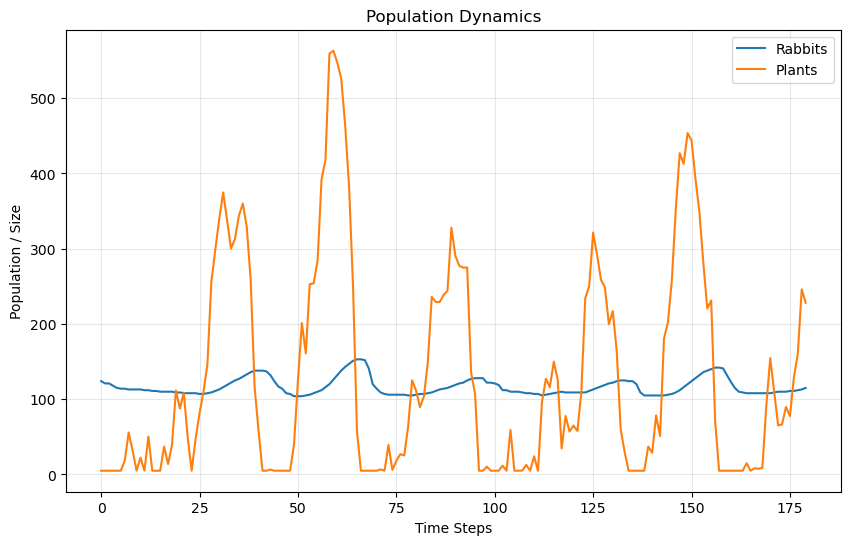

In [33]:


rabbits = []
plants = []
wolves = []

for step in report:
    rabbits.append(step['num_rabbits'])
    wolves.append(step['num_wolves'])
    plants.append(step['plant_size'])

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(rabbits[20:], label='Rabbits')
# plt.plot(wolves, label='Wolves')
plt.plot(plants[20:], label='Plants')
plt.xlabel('Time Steps')

plt.ylabel('Population / Size')
plt.title('Population Dynamics')
plt.legend()
plt.grid(alpha=0.3)
plt.show()